In [1]:
!nvidia-smi

Sun Aug  3 20:53:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8             12W /   65W |     189MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

def check_gpu():
    print("="*40)
    if torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_name = torch.cuda.get_device_name(0)
        total_mem = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)
        capability = torch.cuda.get_device_capability(0)
        print("✅ GPU is available and being used.")
        print(f"🖥️  Device     : {gpu_name}")
        print(f"💾 Memory     : {total_mem:.2f} GB")
        print(f"⚙️  Capability : {capability}")
        print(f"📌 Torch Device : {device}")
    else:
        device = torch.device("cpu")
        print("❌ GPU not available. Using CPU instead.")
        print(f"📌 Torch Device : {device}")
    print("="*40)

check_gpu()


✅ GPU is available and being used.
🖥️  Device     : NVIDIA GeForce RTX 3060 Laptop GPU
💾 Memory     : 6.00 GB
⚙️  Capability : (8, 6)
📌 Torch Device : cuda


In [3]:
# Cell 1 — Imports & Config

import os, random
from datetime import datetime

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    classification_report
)

# Device & seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

# ImageNet normalization
IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]


In [4]:
# Cell 2 — Dataset (OpenCV, one random frame per video)

class VideoFrameDataset(Dataset):
    def __init__(self, root_dir, folders, transform=None):
        self.samples = []
        for label, f in enumerate(folders):
            p = os.path.join(root_dir, f)
            for fname in os.listdir(p):
                full = os.path.join(p, fname)
                if os.path.isfile(full):
                    self.samples.append((full, label))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise RuntimeError(f"Cannot open {video_path}")
        n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        if n <= 0:
            raise RuntimeError(f"No frames in {video_path}")

        frame_idx = random.randint(0, n - 1)
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ok, frame = cap.read()
        cap.release()
        if not ok:
            raise RuntimeError(f"Failed read frame {frame_idx} from {video_path}")

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)
        if self.transform:
            img = self.transform(img)
        return img, label


In [5]:
# Cell 3 — Transforms & DataLoaders

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

data_root = "../subset"
folders   = ['DFD_original_sequences','DFD_manipulated_sequences']

full_ds = VideoFrameDataset(data_root, folders, transform)
n_train = int(0.8 * len(full_ds))
n_val   = len(full_ds) - n_train
train_ds, val_ds = torch.utils.data.random_split(full_ds, [n_train, n_val])

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [7]:
# Cell 4 — XceptionNet Model (torchvision → fallback to timm)

import torch.nn as nn

class XceptionVideo(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # try torchvision’s xception (if your torchvision is recent),
        # else fall back to timm’s implementation
        try:
            backbone = models.xception(pretrained=True)
            feat_in = backbone.fc.in_features
            backbone.fc = nn.Identity()
        except AttributeError:
            import timm
            backbone = timm.create_model('xception', pretrained=True)
            # timm models expose num_features
            feat_in = backbone.num_features
            # remove whatever head it has
            if hasattr(backbone, 'fc'):
                backbone.fc = nn.Identity()
            elif hasattr(backbone, 'classifier'):
                backbone.classifier = nn.Identity()

        self.backbone = backbone
        # our simple classifier on top
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(feat_in, num_classes)
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)

# instantiate on device
model = XceptionVideo(num_classes=2).to(device)


c:\Users\mohit\Desktop\PROJECTS\AI Image Detection\resnet-50\resnet_env_gpu\lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to C:\Users\mohit/.cache\torch\hub\checkpoints\xception-43020ad28.pth


In [8]:
# Cell 5 — Trainer with extended metrics

class Trainer:
    def __init__(self, model, train_loader, val_loader, device,
                 lr=1e-4, ckpt_dir="xceptionNet_checkpoints"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader   = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.ckpt_dir = ckpt_dir
        os.makedirs(ckpt_dir, exist_ok=True)

        self.history = {k: [] for k in [
            "train_loss","train_acc",
            "val_loss","val_acc","val_prec","val_rec","val_f1",
            "val_roc_auc","val_pr_auc"
        ]}

    def train_epoch(self, epoch):
        self.model.train()
        running_loss, preds, trues = 0.0, [], []
        loop = tqdm(self.train_loader, desc=f"Epoch {epoch} ▶ Train", unit="batch", leave=True, dynamic_ncols=True)
        for imgs, labels in loop:
            imgs, labels = imgs.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
            out = self.model(imgs)
            loss = self.criterion(out, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds.extend(out.argmax(1).cpu().tolist())
            trues.extend(labels.cpu().tolist())

            loop.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc":  f"{100*accuracy_score(trues, preds):.2f}%",
                "lr":   f"{self.optimizer.param_groups[0]['lr']:.1e}"
            })

        epoch_loss = running_loss / len(trues)
        epoch_acc  = accuracy_score(trues, preds)
        self.history["train_loss"].append(epoch_loss)
        self.history["train_acc"].append(epoch_acc)
        print(f"→ Train: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}")

    def validate_epoch(self, epoch):
        self.model.eval()
        running_loss, probs, trues = 0.0, [], []
        loop = tqdm(self.val_loader, desc=f"Epoch {epoch} ▶ Valid", unit="batch", leave=True, dynamic_ncols=True)
        with torch.no_grad():
            for imgs, labels in loop:
                imgs, labels = imgs.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
                out = self.model(imgs)
                loss = self.criterion(out, labels)

                running_loss += loss.item() * imgs.size(0)
                p = torch.softmax(out, dim=1)[:,1]
                probs.extend(p.cpu().tolist())
                trues.extend(labels.cpu().tolist())

                loop.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc":  f"{100*accuracy_score(trues, [x>0.5 for x in probs]):.2f}%"
                })

        val_loss = running_loss / len(trues)
        val_acc  = accuracy_score(trues, [x>0.5 for x in probs])
        prec, rec, f1, _ = precision_recall_fscore_support(trues, [x>0.5 for x in probs], average='binary', zero_division=0)
        fpr, tpr, _    = roc_curve(trues, probs)
        roc_auc         = auc(fpr, tpr)
        pr, rc, _       = precision_recall_curve(trues, probs)
        pr_auc          = average_precision_score(trues, probs)

        self.history["val_loss"].append(val_loss)
        self.history["val_acc"].append(val_acc)
        self.history["val_prec"].append(prec)
        self.history["val_rec"].append(rec)
        self.history["val_f1"].append(f1)
        self.history["val_roc_auc"].append(roc_auc)
        self.history["val_pr_auc"].append(pr_auc)

        print(f"→ Valid: loss={val_loss:.4f}, acc={val_acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}")
        return val_acc, (fpr, tpr, pr, rc, trues, probs)

    def save_checkpoint(self, epoch, best=False):
        fn = f"epoch_{epoch}.pth" if not best else "best_model.pth"
        path = os.path.join(self.ckpt_dir, fn)
        torch.save({
            "epoch": epoch,
            "model_state": self.model.state_dict(),
            "optim_state": self.optimizer.state_dict()
        }, path)
        print(f"[Checkpoint] Saved {fn}")

    def fit(self, epochs=20):
        best_acc = 0.0
        for ep in range(1, epochs+1):
            print(f"\n=== Epoch {ep}/{epochs} ===")
            self.train_epoch(ep)
            val_acc, roc_pr = self.validate_epoch(ep)
            self.save_checkpoint(ep)
            if val_acc > best_acc:
                best_acc = val_acc
                self.save_checkpoint(ep, best=True)
        print(f"\nTraining complete. Best val acc: {best_acc:.4f}")
        return roc_pr


In [9]:
trainer = Trainer(model, train_loader, val_loader, device)


In [10]:
roc_pr_data = trainer.fit(epochs=20)


=== Epoch 1/20 ===


Epoch 1 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.7056, acc=0.4375


Epoch 1 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.6716, acc=0.5750, prec=0.5625, rec=0.8571, f1=0.6792
[Checkpoint] Saved epoch_1.pth
[Checkpoint] Saved best_model.pth

=== Epoch 2/20 ===


Epoch 2 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.6402, acc=0.7500


Epoch 2 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.6767, acc=0.5250, prec=0.5556, rec=0.4762, f1=0.5128
[Checkpoint] Saved epoch_2.pth

=== Epoch 3/20 ===


Epoch 3 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.6112, acc=0.7688


Epoch 3 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.7098, acc=0.5000, prec=0.5263, rec=0.4762, f1=0.5000
[Checkpoint] Saved epoch_3.pth

=== Epoch 4/20 ===


Epoch 4 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.5529, acc=0.7688


Epoch 4 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.7330, acc=0.5750, prec=0.6111, rec=0.5238, f1=0.5641
[Checkpoint] Saved epoch_4.pth

=== Epoch 5/20 ===


Epoch 5 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.5081, acc=0.7750


Epoch 5 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.7062, acc=0.5250, prec=0.5556, rec=0.4762, f1=0.5128
[Checkpoint] Saved epoch_5.pth

=== Epoch 6/20 ===


Epoch 6 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.4276, acc=0.8375


Epoch 6 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.8325, acc=0.6000, prec=0.6471, rec=0.5238, f1=0.5789
[Checkpoint] Saved epoch_6.pth
[Checkpoint] Saved best_model.pth

=== Epoch 7/20 ===


Epoch 7 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.4716, acc=0.8187


Epoch 7 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.9759, acc=0.5000, prec=0.5238, rec=0.5238, f1=0.5238
[Checkpoint] Saved epoch_7.pth

=== Epoch 8/20 ===


Epoch 8 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3390, acc=0.8625


Epoch 8 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.9098, acc=0.5250, prec=0.5500, rec=0.5238, f1=0.5366
[Checkpoint] Saved epoch_8.pth

=== Epoch 9/20 ===


Epoch 9 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2921, acc=0.8938


Epoch 9 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.1455, acc=0.4500, prec=0.4737, rec=0.4286, f1=0.4500
[Checkpoint] Saved epoch_9.pth

=== Epoch 10/20 ===


Epoch 10 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3404, acc=0.8688


Epoch 10 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.0816, acc=0.6000, prec=0.6190, rec=0.6190, f1=0.6190
[Checkpoint] Saved epoch_10.pth

=== Epoch 11/20 ===


Epoch 11 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2737, acc=0.8875


Epoch 11 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.0767, acc=0.6000, prec=0.6316, rec=0.5714, f1=0.6000
[Checkpoint] Saved epoch_11.pth

=== Epoch 12/20 ===


Epoch 12 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3210, acc=0.8500


Epoch 12 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.9705, acc=0.5250, prec=0.5500, rec=0.5238, f1=0.5366
[Checkpoint] Saved epoch_12.pth

=== Epoch 13/20 ===


Epoch 13 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2662, acc=0.8750


Epoch 13 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.1756, acc=0.4250, prec=0.4545, rec=0.4762, f1=0.4651
[Checkpoint] Saved epoch_13.pth

=== Epoch 14/20 ===


Epoch 14 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2856, acc=0.8688


Epoch 14 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.1251, acc=0.5500, prec=0.5789, rec=0.5238, f1=0.5500
[Checkpoint] Saved epoch_14.pth

=== Epoch 15/20 ===


Epoch 15 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2463, acc=0.8938


Epoch 15 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.1165, acc=0.5750, prec=0.6111, rec=0.5238, f1=0.5641
[Checkpoint] Saved epoch_15.pth

=== Epoch 16/20 ===


Epoch 16 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2249, acc=0.8938


Epoch 16 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.2496, acc=0.5500, prec=0.5882, rec=0.4762, f1=0.5263
[Checkpoint] Saved epoch_16.pth

=== Epoch 17/20 ===


Epoch 17 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2266, acc=0.9125


Epoch 17 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.1306, acc=0.5000, prec=0.5217, rec=0.5714, f1=0.5455
[Checkpoint] Saved epoch_17.pth

=== Epoch 18/20 ===


Epoch 18 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2196, acc=0.8938


Epoch 18 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.1847, acc=0.5000, prec=0.5238, rec=0.5238, f1=0.5238
[Checkpoint] Saved epoch_18.pth

=== Epoch 19/20 ===


Epoch 19 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2011, acc=0.8938


Epoch 19 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.4259, acc=0.5500, prec=0.5714, rec=0.5714, f1=0.5714
[Checkpoint] Saved epoch_19.pth

=== Epoch 20/20 ===


Epoch 20 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.1819, acc=0.9125


Epoch 20 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.3452, acc=0.6250, prec=0.6500, rec=0.6190, f1=0.6341
[Checkpoint] Saved epoch_20.pth
[Checkpoint] Saved best_model.pth

Training complete. Best val acc: 0.6250


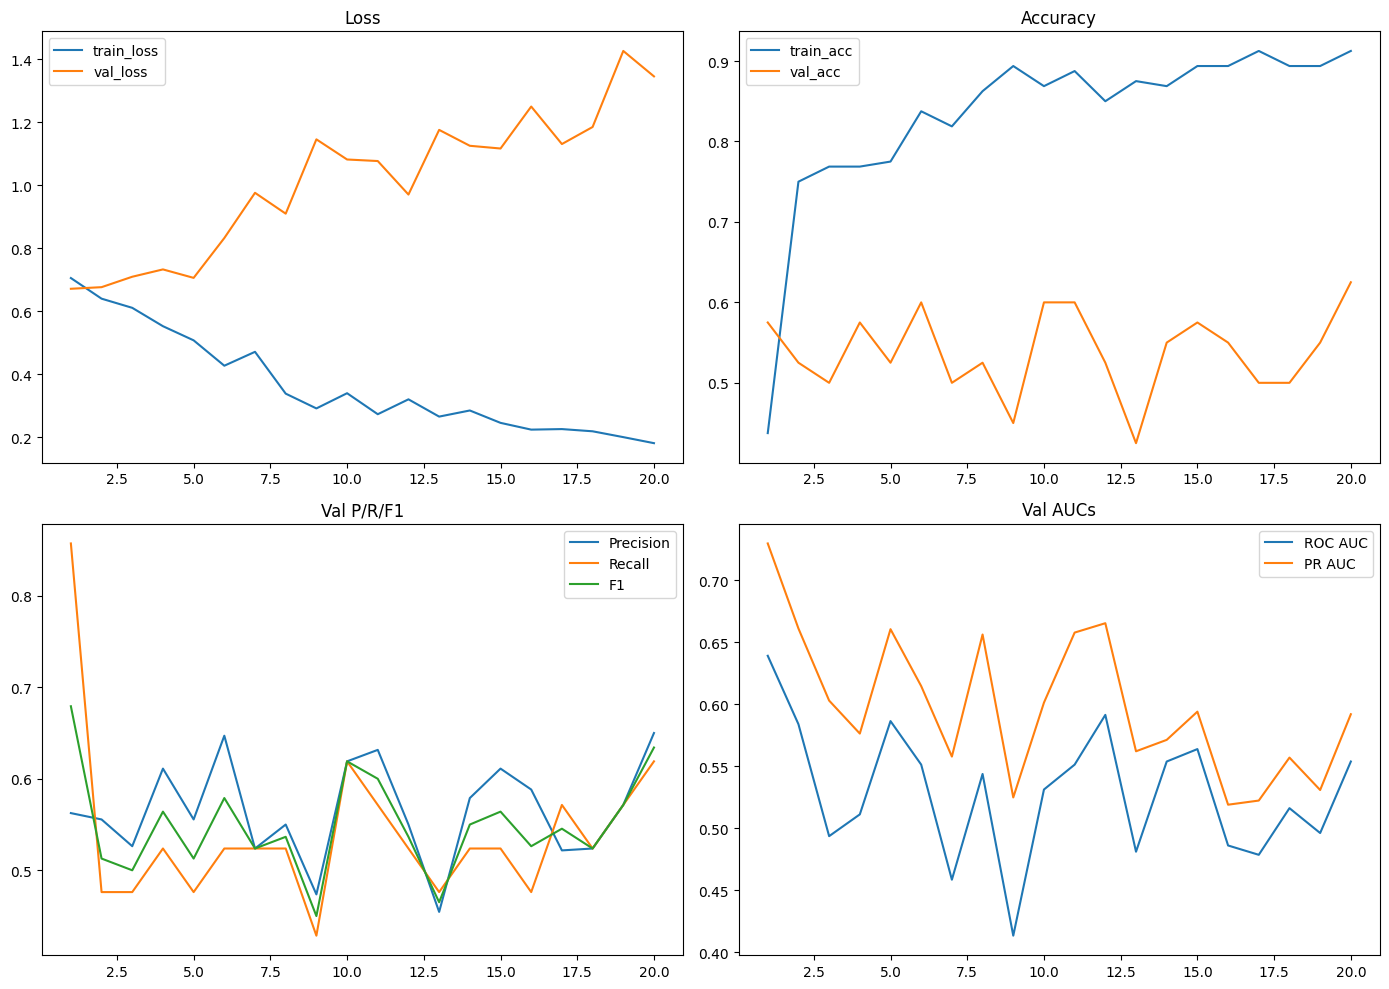

In [11]:
# Cell 7 — Plot Loss, Accuracy & AUCs

h = trainer.history
epo = list(range(1, len(h["train_loss"])+1))

plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(epo, h["train_loss"], label="train_loss")
plt.plot(epo, h["val_loss"] , label="val_loss")
plt.title("Loss"); plt.legend()

plt.subplot(2,2,2)
plt.plot(epo, h["train_acc"], label="train_acc")
plt.plot(epo, h["val_acc"] , label="val_acc")
plt.title("Accuracy"); plt.legend()

plt.subplot(2,2,3)
plt.plot(epo, h["val_prec"], label="Precision")
plt.plot(epo, h["val_rec"] , label="Recall")
plt.plot(epo, h["val_f1"]  , label="F1")
plt.title("Val P/R/F1"); plt.legend()

plt.subplot(2,2,4)
plt.plot(epo, h["val_roc_auc"], label="ROC AUC")
plt.plot(epo, h["val_pr_auc"] , label="PR AUC")
plt.title("Val AUCs"); plt.legend()

plt.tight_layout()
plt.show()


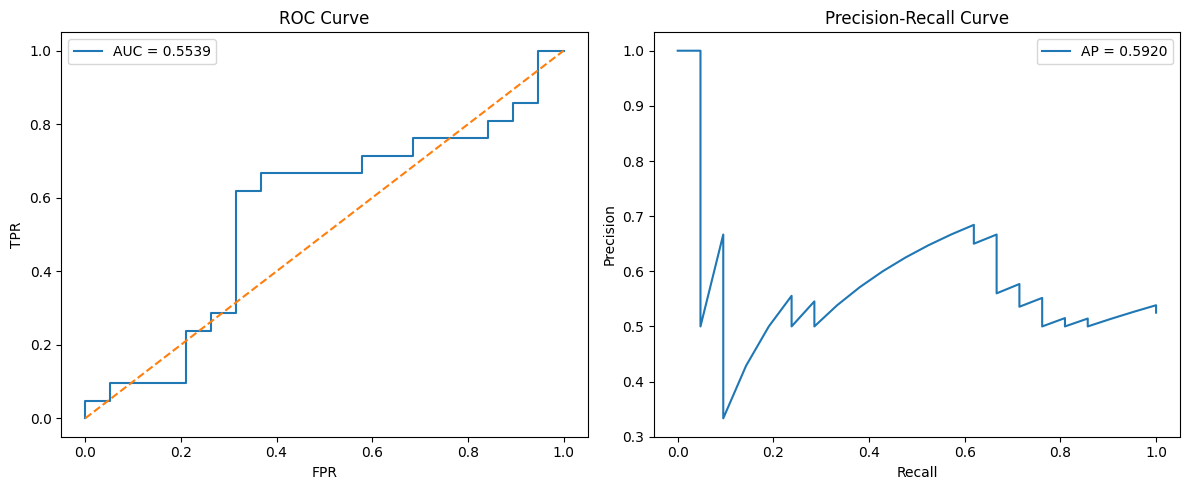

In [12]:
# Cell 8 — ROC & PR curves for final epoch

fpr, tpr, pr, rc, y_true, y_prob = roc_pr_data

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {h['val_roc_auc'][-1]:.4f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rc, pr, label=f"AP = {h['val_pr_auc'][-1]:.4f}")
plt.title("Precision-Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()

plt.tight_layout()
plt.show()


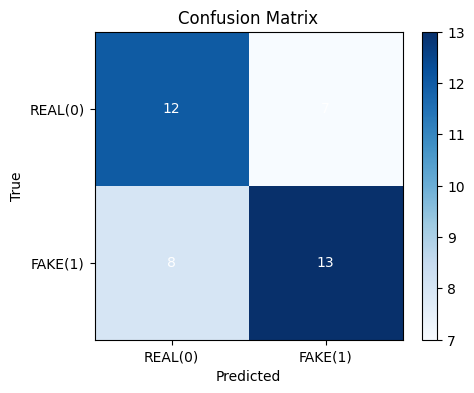


Classification Report:
              precision    recall  f1-score   support

     REAL(0)       0.60      0.63      0.62        19
     FAKE(1)       0.65      0.62      0.63        21

    accuracy                           0.62        40
   macro avg       0.62      0.63      0.62        40
weighted avg       0.63      0.62      0.63        40



In [13]:
# Cell 9 — Confusion Matrix & Classification Report

y_pred = [p>0.5 for p in y_prob]
cm     = confusion_matrix(y_true, y_pred)
labels = ['REAL(0)','FAKE(1)']

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.xticks([0,1], labels); plt.yticks([0,1], labels)
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


In [15]:
# Cell 10 — Save all results to Excel

import pandas as pd
from sklearn.metrics import classification_report

# 1) Epoch‐level metrics
epoch_df = pd.DataFrame(trainer.history)

# 2) ROC curve data
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr
})

# 3) Precision‐Recall curve data
pr_df = pd.DataFrame({
    'recall': rc,
    'precision': pr
})

# 4) Confusion matrix
cm_df = pd.DataFrame(
    cm,
    index=labels,
    columns=labels
)

# 5) Classification report
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=labels,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

# 6) Raw predictions & probabilities
preds_df = pd.DataFrame({
    'y_true':   y_true,
    'y_prob':  y_prob
})

# === Write to Excel with multiple sheets ===
out_file = "XceptionNet_results.xlsx"
with pd.ExcelWriter(out_file, engine='openpyxl') as writer:
    epoch_df.to_excel(writer, sheet_name='epoch_metrics', index=False)
    roc_df.to_excel(writer, sheet_name='roc_curve',     index=False)
    pr_df.to_excel(writer, sheet_name='pr_curve',      index=False)
    cm_df.to_excel(writer, sheet_name='confusion_matrix')
    report_df.to_excel(writer, sheet_name='class_report')
    preds_df.to_excel(writer, sheet_name='predictions',  index=False)

print(f"✅ All results saved to {out_file}")


✅ All results saved to XceptionNet_results.xlsx
